In [83]:
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
import pickle
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
import gensim
from tqdm import tqdm

In [2]:
df = pd.read_csv('Twitter_Data.csv', index_col=False)
df.head()

,clean_text,category
0,when modi promised “minimum government maximum...,-1.0
1,talk all the nonsense and continue all the dra...,0.0
2,what did just say vote for modi welcome bjp t...,1.0
3,asking his supporters prefix chowkidar their n...,1.0
4,answer who among these the most powerful world...,1.0


In [3]:
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 162969 entries, 0 to 162979
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   clean_text  162969 non-null  object 
 1   category    162969 non-null  float64
dtypes: float64(1), object(1)
memory usage: 3.7+ MB


In [16]:
def create_df(df_bow):
    xtrain = df_bow[:int(df_bow.shape[0]*0.8)]
    xtest = df_bow[int(df_bow.shape[0]*0.8):]
    y = np.array(df['category'])
    yN =[]
    for i in y:
        if(i == 1.0):
            yN.append([1,0,0])
        elif(i==0.0):
            yN.append([0,1,0])
        else:
            yN.append([0,0,1])
    ytrain = np.array(yN[:int(df_bow.shape[0]*0.8)])
    ytest = np.array(yN[int(df_bow.shape[0]*0.8):])
    ytrain = np.reshape(ytrain,(ytrain.shape[0],3))
    ytest = np.reshape(ytest,(ytest.shape[0],3))
    return (xtrain,ytrain,xtest,ytest)
            
    

In [20]:
def trainData(lr,epoch,ytrain,x_train,w):
    x = tf.constant(xtrain, dtype=tf.float32)
    opti= Adam(learning_rate=lr)
    iter =epoch
    c=[]
    ytrain=tf.constant(ytrain,dtype=tf.float32)
    loss=tf.keras.losses.CategoricalCrossentropy(reduction=tf.keras.losses.Reduction.SUM)
    for i in range(iter):
        with tf.GradientTape() as tape:
            yhat = tf.nn.softmax(tf.matmul(x,tf.transpose(w)),axis=1)
            cost = loss(yhat, ytrain)

        c.append(cost)
        grad = tape.gradient(cost,[w])
        opti.apply_gradients(zip(grad,[w])) # adma optimizer
    return(c,w)    
        

In [19]:
def showLearningCurve(c):
    l=np.arange(1,len(c)+1)
    plt.plot(l, c, label = "line 2")

    # naming the x axis -->
    plt.xlabel('iteration')
    # naming the y axis
    plt.ylabel('cost')
    # giving a title to my graph
    plt.title('Cost function Recommendor system!')

    # show a legend on the plot
    plt.legend()

    # function to show the plot
    plt.show()

In [21]:
def accuracyAndF1(xtest,y):
    xtest = tf.constant(xtest, dtype=tf.float32)
    yhatN = tf.nn.softmax(tf.matmul(xtest,tf.transpose(w)),axis=1).numpy()
    yhat = []
    for i in yhatN:
        a = np.argmax(i)
        if(a==0):
            yhat.append(1.0)
        elif(a==1):
            yhat.append(0.0)
        else:
            yhat.append(-1.0)
    ytN=np.array(y[int(df_bow.shape[0]*0.8):])
    ytest = np.array(ytN)
    ytest = np.reshape((ytest),(ytest.shape[0],1))
    ytest.shape 
    yhat = np.array(yhat)
    yhat=np.reshape((yhat),(yhat.shape[0],1))
    print(accuracy_score(ytest, yhat))
    print(f1_score(ytest, yhat, average='micro'))

## Bag of words  DataFrame

In [36]:
max_features = 2000

In [61]:
bow = CountVectorizer(stop_words='english',max_features=max_features)
df_bow = cv1.fit_transform(df["clean_text"])
df_bow=df_bow.toarray()
df_bow.shape

(162969, 2500)

In [62]:
with open('Bag_of_words_vectorizer.pkl', 'wb') as fin:
    pickle.dump(bow, fin)

In [38]:
xtrain,ytrain,xtest,ytest =  create_df(df_bow)

In [40]:
w=tf.Variable(tf.random.uniform(shape=[3,max_features], minval=0,maxval=15, dtype=tf.float32, seed=123456789))
c,weights_BOW= trainData(1e-1,300,ytrain,xtrain,w)
weights_BOW

<tf.Variable 'Variable:0' shape=(3, 2000) dtype=float32, numpy=
array([[ 9.53178  ,  2.779921 ,  7.1612725, ...,  5.488206 , 11.738838 ,
         9.428514 ],
       [11.418312 ,  6.4107943, 11.731164 , ...,  7.4617677,  9.884328 ,
        10.79973  ],
       [ 6.469105 ,  3.558635 ,  6.63434  , ...,  5.636131 ,  9.276362 ,
         9.636646 ]], dtype=float32)>

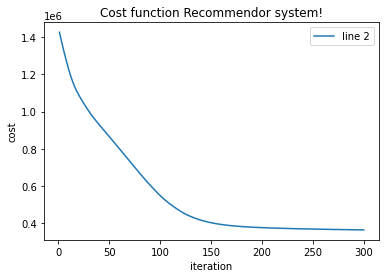

In [41]:
showLearningCurve(c)

In [42]:
accuracyAndF1(xtest,np.array(df['category']))

0.7861876418972817
0.7861876418972816


In [43]:
np.savetxt("SoftmaxWeights_BOW.csv", weights_BOW, delimiter=",")

## Ngrams n=2 dataframe can not make dataset as memory issue 

In [46]:
max_feature = 2500

In [59]:
ngrams = CountVectorizer(stop_words='english',ngram_range=(1, 3),max_features=2500)
df_bow = cv1.fit_transform(df["clean_text"])
df_bow=df_bow.toarray()
df_bow.shape

(162969, 2500)

In [60]:
with open('N-GRAMS_vectorizer.pkl', 'wb') as fin:
    pickle.dump(ngrams, fin)

In [47]:
xtrain,ytrain,xtest,ytest =  create_df(df_bow)
xtrain.shape

(130375, 2500)

In [48]:
w=tf.Variable(tf.random.uniform(shape=[3,max_feature], minval=0,maxval=15, dtype=tf.float32, seed=123456789))
c,weights_Ngrams= trainData(1e-1,300,ytrain,xtrain,w)
weights_Ngrams

<tf.Variable 'Variable:0' shape=(3, 2500) dtype=float32, numpy=
array([[ 9.171355 ,  7.1902637,  6.267326 , ...,  7.536232 ,  6.7786717,
        10.805975 ],
       [11.5243025, 10.208642 ,  9.757872 , ...,  7.706666 ,  3.8171875,
        12.214117 ],
       [ 7.6567774,  5.4724813,  5.864653 , ...,  6.755416 ,  5.0768347,
         9.921056 ]], dtype=float32)>

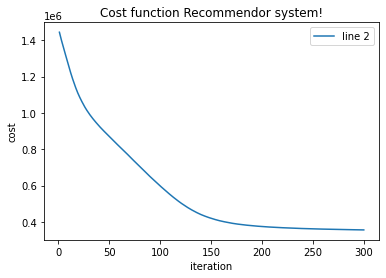

In [49]:
showLearningCurve(c)

In [50]:
accuracyAndF1(xtest,np.array(df['category']))

0.7813094434558507
0.7813094434558507


In [51]:
np.savetxt("SoftmaxWeights_N-Grams.csv", weights_Ngrams, delimiter=",")

## TF - IDF 

In [53]:
max_f = 2500
vectorizer = TfidfVectorizer(stop_words='english',max_features=max_f)
df_bow = cv1.fit_transform(df["clean_text"])
df_bow=df_bow.toarray()
df_bow.shape

(162969, 2500)

In [55]:
xtrain,ytrain,xtest,ytest =  create_df(df_bow)
w=tf.Variable(tf.random.uniform(shape=[3,max_f], minval=0,maxval=15, dtype=tf.float32, seed=123456789))
c,weights_TfIdf= trainData(1e-1,300,ytrain,xtrain,w)

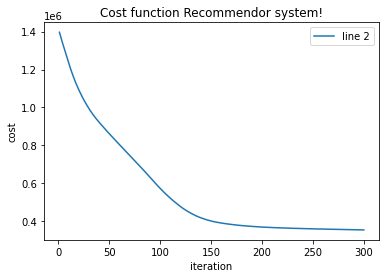

In [56]:
showLearningCurve(c)

In [57]:
accuracyAndF1(xtest,np.array(df['category']))

0.7830889120697061
0.7830889120697061


In [58]:
with open('TF_IDF_vectorizer.pkl', 'wb') as fin:
    pickle.dump(vectorizer, fin)

## Word 2 Vector

In [76]:
ref = df.clean_text.apply(gensim.utils.simple_preprocess)

In [77]:
model_w2v = gensim.models.Word2Vec(window=10,min_count=2)

In [78]:
model_w2v.build_vocab(ref)

In [79]:
model_w2v.train(ref,total_examples = model_w2v.corpus_count,epochs=model_w2v.epochs)

(13218852, 16159375)

In [80]:
def docVector(doc):
    doc = [word for word in doc.split() if word in model_w2v.wv.index_to_key]
    return np.mean(model_w2v.wv[doc],axis=0)

In [ ]:
X = []
for i in tqdm(df['clean_text'].values):
    X.append( docVector(i))
len(X)    